In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from netcal.metrics import ECE, ACE

from utils_notebook import *

from collections import OrderedDict, Counter
import random
from typing import Dict

import pandas as pd

import pickle

/home/metod/miniconda3/envs/msdnet2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## CIFAR-100

MODEL_FOLDER = 'models'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH)

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [3]:
# ## CIFAR-10

# MODEL_FOLDER = 'cifar10/models'
# LIKELIHOOD = 'softmax'
# EPOCH = "049"

# logits, targets, ARGS = get_logits_targets('cifar10', MODEL_FOLDER, LIKELIHOOD, EPOCH)

In [4]:
# ## ImageNet

# with open(f'output/ImageNet.p', 'rb') as f:
#     data = pickle.load(f)
# logits, targets, ARGS = data

In [5]:
L = len(logits)
N = len(targets)

## 1 Ablations

In [6]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

In [7]:
probs = torch.softmax(logits, dim=2)
probs_de = probs.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
preds_de = {i: torch.argmax(probs_de, dim=2)[i, :] for i in range(L)}
acc_de = [(targets == preds_de[i]).sum() / len(targets) for i in range(L)]

In [8]:
logits_poe = logits.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
probs_poe = torch.softmax(logits_poe, dim=2)
preds_poe = {i: torch.argmax(probs_poe, dim=2)[i, :] for i in range(L)}
acc_poe = [(targets == preds_poe[i]).sum() / len(targets) for i in range(L)]

In [9]:
probs_ovr = ovr_likelihood(logits)
preds_ovr = {i: torch.argmax(probs_ovr, dim=2)[i, :] for i in range(L)}
acc_ovr = [(targets == preds_ovr[i]).sum() / len(targets) for i in range(L)]

In [10]:
probs_ovr = ovr_likelihood(logits)
probs_moe_ovr = probs_ovr.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
preds_moe_ovr = {i: torch.argmax(probs_moe_ovr, dim=2)[i, :] for i in range(L)}
acc_moe_ovr = [(targets == preds_moe_ovr[i]).sum() / len(targets) for i in range(L)]

In [11]:
probs_ovr = ovr_likelihood(logits)
probs_poe_ovr = f_probs_ovr_poe(probs_ovr)
preds_poe_ovr = {i: torch.argmax(probs_poe_ovr, dim=2)[i, :] for i in range(L)}
acc_poe_ovr = [(targets == preds_poe_ovr[i]).sum() / len(targets) for i in range(L)]

In [12]:
probs_ovr_break_ties = torch.tensor(f_probs_ovr_logits_weighted(logits))
preds_ovr_break_ties = {i: torch.argmax(probs_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_ovr_break_ties = [(targets == preds_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

In [13]:
# probs_ovr_break_ties = torch.tensor(f_probs_ovr_logits_weighted(logits))
# probs_moe_ovr_break_ties = probs_ovr_break_ties.cumsum(dim=0) / torch.tensor([float(x) for x in range(1, L + 1)])[:, None, None]
probs_moe_ovr_break_ties = torch.tensor(moe_relu(logits))
# probs_moe_ovr_break_ties = torch.tensor(moe_relu_weighted(logits))
# probs_moe_ovr_break_ties = torch.tensor(f_probs_ovr_moe_logits_weighted_generalized(logits))
preds_moe_ovr_break_ties = {i: torch.argmax(probs_moe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_moe_ovr_break_ties = [(targets == preds_moe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

In [14]:
T = 1.
# probs_poe_ovr_break_ties = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits))
probs_poe_ovr_break_ties = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr_break_ties = {i: torch.argmax(probs_poe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties = [(targets == preds_poe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

In [15]:
# probs_poe_ovr_break_ties_softmax = torch.tensor(f_probs_ovr_poe_logits_softmax(logits, L=L))
# preds_poe_ovr_break_ties_softmax = {i: torch.argmax(probs_poe_ovr_break_ties_softmax, dim=2)[i, :] for i in range(L)}
# acc_poe_ovr_break_ties_softmax = [(targets == preds_poe_ovr_break_ties_softmax[i]).sum() / len(targets) for i in range(L)]

In [16]:
# UPDATE May 2023: excluding MoE from ablations...


THRESHOLDS_MONOTONE = [-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5]

df_accuracy = pd.DataFrame(columns=[l for l in range(1, L+1)])
df_monotone = pd.DataFrame(columns=THRESHOLDS_MONOTONE)
df_monotone_rel = pd.DataFrame(columns=THRESHOLDS_MONOTONE)
df_monotone_gt = pd.DataFrame(columns=THRESHOLDS_MONOTONE)
df_monotone_gt_rel = pd.DataFrame(columns=THRESHOLDS_MONOTONE)
for likelihood, ensemble_type, _acc, _probs, _preds in [("softmax", "/", acc, probs, preds),
                                                        ("softmax", "MoE", acc_de, probs_de, preds_de),
                                                        ("softmax", "PoE", acc_poe, probs_poe, preds_poe),
                                                        ("Heaviside", "/", acc_ovr, probs_ovr, preds_ovr),
                                                        ("Heaviside", "MoE", acc_moe_ovr, probs_moe_ovr, preds_moe_ovr),
                                                        ("Heaviside", "PoE", acc_poe_ovr, probs_poe_ovr, preds_poe_ovr),
                                                        ("ReLU", "/", acc_ovr_break_ties, probs_ovr_break_ties, preds_ovr_break_ties),
                                                        ("ReLU", "MoE", acc_moe_ovr_break_ties, probs_moe_ovr_break_ties, preds_moe_ovr_break_ties),
                                                        ("ReLU", "PoE", acc_poe_ovr_break_ties, probs_poe_ovr_break_ties, preds_poe_ovr_break_ties),
                                                        # ("softmax OvR", "PoE", acc_poe_ovr_break_ties_softmax, probs_poe_ovr_break_ties_softmax, preds_poe_ovr_break_ties_softmax)
                                                        ]:
    if _acc:
        df_accuracy.loc[f'{likelihood}+{ensemble_type}', :] = [round(float(x), 4) * 100 for x in _acc]
        df_monotone.loc[f'{likelihood}+{ensemble_type}', :] = [round(x, 4) for x in modal_probs_decreasing(_preds, _probs, L, N=N, thresholds=THRESHOLDS_MONOTONE, diffs_type="all").values()]
        df_monotone_rel.loc[f'{likelihood}+{ensemble_type}', :] = [round(x, 4) for x in modal_probs_decreasing_relative(_preds, _probs, L, N=N, thresholds=THRESHOLDS_MONOTONE, diffs_type="all").values()]
        df_monotone_gt.loc[f'{likelihood}+{ensemble_type}', :] = [round(x, 4) for x in modal_probs_decreasing(targets, _probs, layer=None, N=N, thresholds=THRESHOLDS_MONOTONE, diffs_type="all").values()]
        df_monotone_gt_rel.loc[f'{likelihood}+{ensemble_type}', :] = [round(x, 4) for x in modal_probs_decreasing_relative(targets, _probs, layer=None, N=N, thresholds=THRESHOLDS_MONOTONE, diffs_type="all").values()]
        

In [17]:
df_accuracy

,1,2,3,4,5,6,7
softmax+/,65.13,68.11,70.65,72.23,72.64,72.86,72.86
softmax+MoE,65.13,69.96,72.9,74.38,75.36,75.79,76.04
softmax+PoE,65.13,70.31,73.48,74.56,75.54,75.94,76.19
Heaviside+/,2.25,2.27,2.42,2.45,2.28,2.34,2.21
Heaviside+MoE,2.25,3.11,3.79,4.3,4.72,5.0,5.2
Heaviside+PoE,2.25,3.11,3.79,4.3,4.72,5.0,5.2
ReLU+/,65.13,68.11,70.65,72.23,72.64,72.86,72.86
ReLU+MoE,65.13,70.19,73.34,74.41,75.52,75.9,76.27
ReLU+PoE,65.13,70.27,73.43,74.8,75.52,75.67,75.59


In [18]:
df_monotone

,-0.0001,-0.0100,-0.0500,-0.1000,-0.2000,-0.2500,-0.3300,-0.5000
softmax+/,86.55,67.37,56.28,49.78,41.67,38.21,32.93,23.15
softmax+MoE,67.79,53.94,41.1,30.51,17.27,12.58,7.77,1.67
softmax+PoE,64.16,44.07,31.17,22.3,12.3,8.84,5.2,1.23
Heaviside+/,92.47,40.51,0.0,0.0,0.0,0.0,0.0,0.0
Heaviside+MoE,84.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Heaviside+PoE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ReLU+/,96.57,63.99,0.18,0.0,0.0,0.0,0.0,0.0
ReLU+MoE,65.31,7.85,0.01,0.0,0.0,0.0,0.0,0.0
ReLU+PoE,0.36,0.12,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df_monotone_rel

,-0.0001,-0.0100,-0.0500,-0.1000,-0.2000,-0.2500,-0.3300,-0.5000
softmax+/,86.59,68.7,59.71,55.16,50.15,48.13,45.08,39.29
softmax+MoE,67.82,55.4,47.31,41.6,31.14,26.38,18.89,4.72
softmax+PoE,64.18,45.13,34.85,28.44,20.23,16.73,12.51,5.78
Heaviside+/,92.47,92.47,85.89,69.33,42.71,40.72,40.51,40.51
Heaviside+MoE,92.5,72.73,16.7,2.1,0.01,0.0,0.0,0.0
Heaviside+PoE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ReLU+/,96.72,95.0,84.91,64.69,28.32,17.22,7.89,1.43
ReLU+MoE,66.43,55.73,27.31,11.75,2.01,0.76,0.14,0.0
ReLU+PoE,0.37,0.33,0.12,0.03,0.0,0.0,0.0,0.0


In [20]:
df_monotone_gt

,-0.0001,-0.0100,-0.0500,-0.1000,-0.2000,-0.2500,-0.3300,-0.5000
softmax+/,86.46,66.09,54.21,47.75,40.24,37.29,32.88,24.8
softmax+MoE,69.09,50.93,36.22,26.09,14.46,10.6,6.58,1.69
softmax+PoE,65.76,42.37,28.74,20.62,12.17,9.24,6.27,2.65
Heaviside+/,99.46,0.79,0.0,0.0,0.0,0.0,0.0,0.0
Heaviside+MoE,84.33,0.09,0.0,0.0,0.0,0.0,0.0,0.0
Heaviside+PoE,0.66,0.66,0.04,0.0,0.0,0.0,0.0,0.0
ReLU+/,97.09,69.04,0.46,0.0,0.0,0.0,0.0,0.0
ReLU+MoE,67.92,9.37,0.01,0.0,0.0,0.0,0.0,0.0
ReLU+PoE,13.06,10.05,1.1,0.05,0.0,0.0,0.0,0.0


In [21]:
df_monotone_gt_rel

,-0.0001,-0.0100,-0.0500,-0.1000,-0.2000,-0.2500,-0.3300,-0.5000
softmax+/,86.77,69.26,60.83,56.8,52.52,50.86,48.48,44.4
softmax+MoE,69.85,57.89,50.71,46.12,38.33,34.63,28.57,14.47
softmax+PoE,66.59,48.94,40.8,36.19,31.12,28.74,25.79,19.95
Heaviside+/,99.46,99.46,90.46,61.28,5.79,1.28,0.8,0.79
Heaviside+MoE,92.43,72.85,17.32,2.88,0.59,0.48,0.4,0.12
Heaviside+PoE,0.66,0.66,0.66,0.66,0.66,0.66,0.66,0.66
ReLU+/,97.21,95.68,86.52,68.25,35.22,24.34,14.44,5.51
ReLU+MoE,68.89,58.92,31.85,16.1,5.11,3.33,1.75,0.36
ReLU+PoE,13.09,12.7,11.32,9.92,7.53,6.67,5.68,4.03


In [22]:
df_monotone.drop(-0.0001, axis=1, inplace=True)
df_monotone_rel.drop(-0.0001, axis=1, inplace=True)
df_monotone_gt.drop(-0.0001, axis=1, inplace=True)
df_monotone_gt_rel.drop(-0.0001, axis=1, inplace=True)

In [23]:
import matplotlib
# import Line2D for custom legends
from matplotlib.lines import Line2D
 

text_width = 5.50107 # in  --> Confirmed with template explanation
dpi = 300

fs_m1 = 6  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9 #  figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1, dpi=dpi, autolayout=True)  # fontsize of the figure 
matplotlib.rc('lines', linewidth=1, markersize=3)
matplotlib.rc('savefig', dpi=1200, bbox='tight')
matplotlib.rc('grid', alpha=0.3)
matplotlib.rc('axes', grid=True)

matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

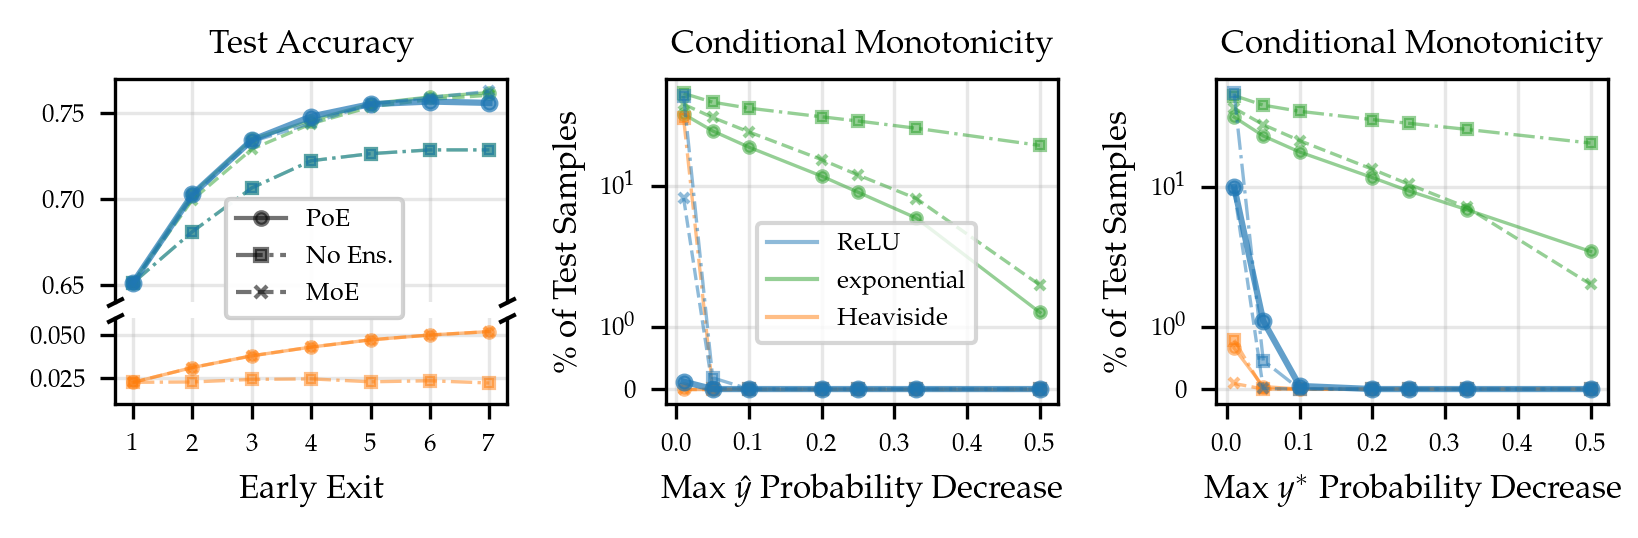

In [24]:
fig = plt.figure(figsize=(text_width, text_width * 4/12))
gs = matplotlib.gridspec.GridSpec(1, 3, figure=fig)
gs0 = gs[0].subgridspec(2, 1, hspace=0.1, height_ratios=[0.77-0.64, 0.06-0.01])

colors = {'softmax': 'tab:green', 'Heaviside': 'tab:orange', 'ReLU': 'tab:blue'}
line_styles = {'/': '-.', 'MoE': '--', 'PoE': '-'}
marker_styles = {'PoE': 'o', 'MoE': 'x', '/': 's'}
# line_styles = {'/': '-.', 'PoE': '-'}
# marker_styles = {'PoE': 'o',  '/': 's'}

ax = [fig.add_subplot(gs0[0]), fig.add_subplot(gs0[1]), fig.add_subplot(gs[:, 1]), fig.add_subplot(gs[:, 2])]

ours_kwargs = {'lw': 1.5, 'ms':3.3, 'alpha':0.7}
default_kwargs = {'lw': 0.8, 'ms':2.5, 'alpha':0.5}

# Create the accuracy plot
for name, accs in df_accuracy.iterrows():
    likelihood, ensemble_type = name.split('+')
    if likelihood == 'softmax OvR':
        continue
    if ensemble_type == 'PoE' and likelihood == 'ReLU':
        kwargs = ours_kwargs
    else:
        kwargs = default_kwargs
    ax[0].plot(list(df_accuracy.columns), accs / 100, marker=marker_styles[ensemble_type], label=name, color=colors[likelihood], ls=line_styles[ensemble_type], **kwargs)

# ax[0].set_xlabel('Early Exit')
# ax[0].set_ylabel('Accuracy')
ax[0].set_title('Test Accuracy')
# set log scale
# ax[0].set_yscale('symlog')
# ax[0].set_yticks([1, 3, 10, 10, 100])
ax[0].set_ylim([0.64, 0.77])


for name, accs in df_accuracy.iterrows():
    likelihood, ensemble_type = name.split('+')
    if likelihood == 'softmax OvR':
        continue
    if ensemble_type == 'PoE' and likelihood == 'ReLU':
        kwargs = ours_kwargs
    else:
        kwargs = default_kwargs
    ax[1].plot(list(df_accuracy.columns), accs / 100, marker=marker_styles[ensemble_type], label=name, color=colors[likelihood], ls=line_styles[ensemble_type], **kwargs)

ax[1].set_xlabel('Early Exit')
ax[1].set_xticks([l for l in range(1, L + 1)])
# ax[1].set_ylabel('Accuracy')
# ax[1].set_title('Test Accuracy')
# set log scale
# ax[1].set_yscale('symlog')
# ax[1].set_yticks([1, 3, 10, 10, 100])
ax[1].set_ylim([0.01, 0.06])

# fig.supylabel('Accuracy', fontsize=fs)
ax[0].spines.bottom.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[0].tick_params(axis='x', which='both',length=0, labelbottom=False)
# ax[0].xaxis.no_ticks()
# ax[0].tick_params(labeltop=False)  # don't put tick labels at the top
ax[1].xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=4,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)



# create the relative monotonicity plot
for name, drops in df_monotone.iterrows():
    likelihood, ensemble_type = name.split('+')
    if likelihood == 'softmax OvR':
        continue
    if ensemble_type == 'PoE' and likelihood == 'ReLU':
        kwargs = ours_kwargs
    else:
        kwargs = default_kwargs
    ax[2].plot(-1 * np.array(df_monotone.columns), drops, marker=marker_styles[ensemble_type], label=name, color=colors[likelihood], ls=line_styles[ensemble_type], **kwargs)

ax[2].set_xlabel('Max $\hat{y}$ Probability Decrease')
ax[2].set_ylabel('\% of Test Samples')
ax[2].set_title('Conditional Monotonicity')
ax[2].set_yscale('symlog')
ax[2].set_xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5])


for name, drops in df_monotone_gt.iterrows():
    likelihood, ensemble_type = name.split('+')
    if likelihood == 'softmax OvR':
        continue
    if ensemble_type == 'PoE' and likelihood == 'ReLU':
        kwargs = ours_kwargs
    else:
        kwargs = default_kwargs
    ax[3].plot(-1 * np.array(df_monotone_gt.columns), drops, marker=marker_styles[ensemble_type], label=name, color=colors[likelihood], ls=line_styles[ensemble_type], **kwargs)

ax[3].set_xlabel('Max $y^*$ Probability Decrease')
ax[3].set_ylabel('\% of Test Samples')
ax[3].set_title('Conditional Monotonicity')
ax[3].set_yscale('symlog')
ax[3].set_xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5])

# lines = [
#     Line2D([0], [0], color='black', lw=1, linestyle='-', marker='o', alpha=0.5),
#     # Line2D([0], [0], color='black', lw=1, linestyle='--', marker='x', alpha=0.5),
#     Line2D([0], [0], color='black', lw=1, linestyle='-.', marker='s', alpha=0.5),
#     Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', alpha=0.5),
#     Line2D([0], [0], color='tab:green', lw=1, linestyle='-', alpha=0.5),
#     Line2D([0], [0], color='tab:orange', lw=1, linestyle='-', alpha=0.5),
# ]
# labels = [
#     "PoE",
#     # "MoE",
#     "No Ens.",
#     "ReLU",
#     "exponential",
#     "heaviside",
# ]
# ax[1].legend(lines, labels, ncol=2, bbox_to_anchor=(0.18, .85), loc='lower left')



# lines1 = [
#     Line2D([0], [0], color='black', lw=1, linestyle='-', marker='o', alpha=0.5),
#     Line2D([0], [0], color='black', lw=1, linestyle='-.', marker='s', alpha=0.5),
# ]
# labels1 = [
#     "PoE",
#     "No Ens.",
# ]

lines1 = [
    Line2D([0], [0], color='black', lw=1, linestyle='-', marker='o', alpha=0.5),
    Line2D([0], [0], color='black', lw=1, linestyle='-.', marker='s', alpha=0.5),
    Line2D([0], [0], color='black', lw=1, linestyle='--', marker='x', alpha=0.5),
]
labels1 = [
    "PoE",
    "No Ens.",
    "MoE"
]

lines2 = [
    Line2D([0], [0], color='tab:blue', lw=1, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='tab:green', lw=1, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='tab:orange', lw=1, linestyle='-', alpha=0.5),
]
labels2 = [
    "ReLU",
    "exponential",
    "Heaviside",
]

legend1 = ax[1].legend(lines1, labels1, loc='lower left', bbox_to_anchor=(0.25, 0.85))
legend2 = ax[2].legend(lines2, labels2, loc='lower left', bbox_to_anchor=(0.2, 0.15))

# Add the legend manually to the current Axes.
ax[1].add_artist(legend1)

plt.tight_layout()
plt.savefig(f'figures/figure_ablation_actv_fun.pdf', dpi=1200, bbox_inches='tight')
plt.show()

## 2 Why MoE-OvR is not muy bien

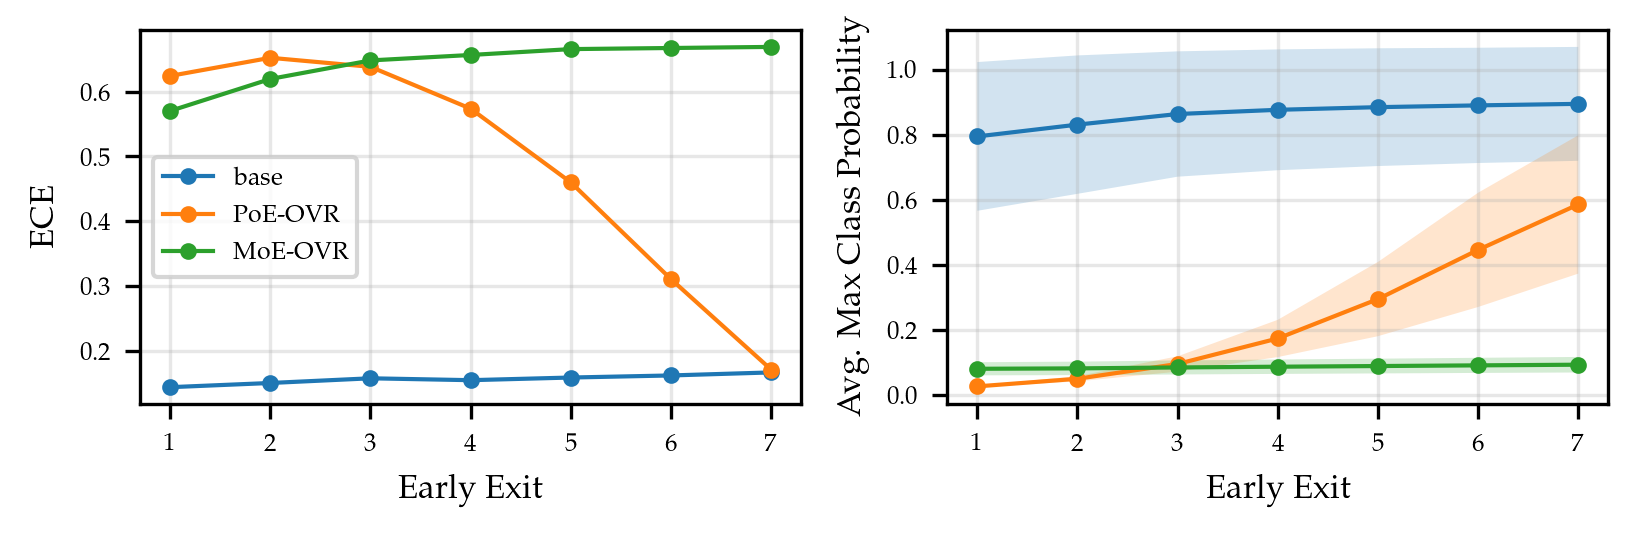

In [48]:
early_exits = list(range(1, L + 1))


fig, ax = plt.subplots(1, 2, figsize=(text_width, text_width * 4/12))
for _probs, label in zip([probs, probs_poe_ovr_break_ties, probs_moe_ovr_break_ties], ['base', 'PoE-OVR', 'MoE-OVR']):
    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets.numpy()))
    ax[0].plot(early_exits, ece, marker='o', label=label)
    mean_magnitude, std_magnitude = _probs.max(2).values.mean(1), _probs.max(2).values.std(1)
    ax[1].plot(early_exits, mean_magnitude, marker='o', label=label)
    ax[1].fill_between(early_exits, mean_magnitude - std_magnitude, mean_magnitude + std_magnitude, alpha=0.2)

ax[0].set_xlabel('Early Exit')
ax[0].set_ylabel('ECE')
ax[0].legend()

ax[1].set_xlabel('Early Exit')
ax[1].set_ylabel('Avg. Max Class Probability')

plt.tight_layout()
plt.savefig(f'figures/figure_ablation_actv_fun_moe_no_muy_bien.pdf', dpi=1200)
plt.show()

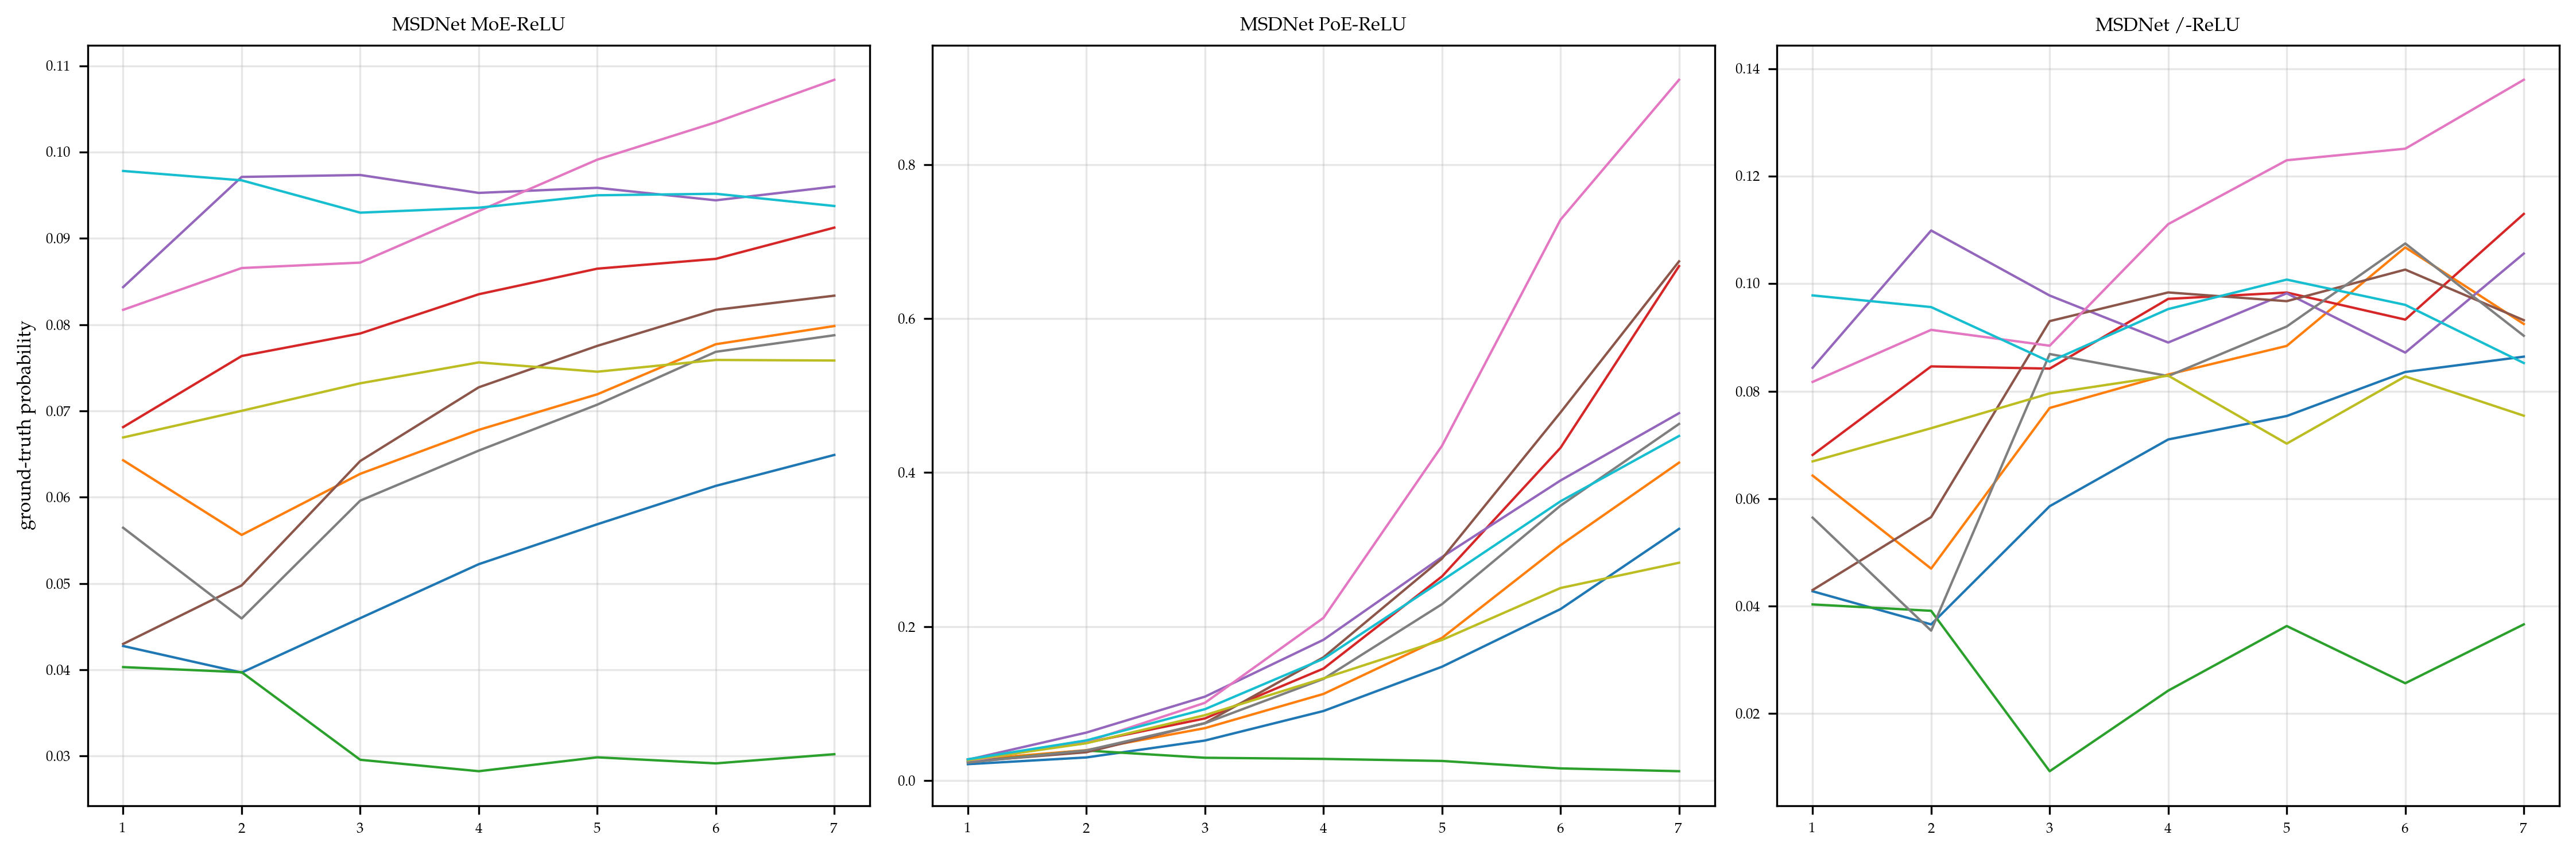

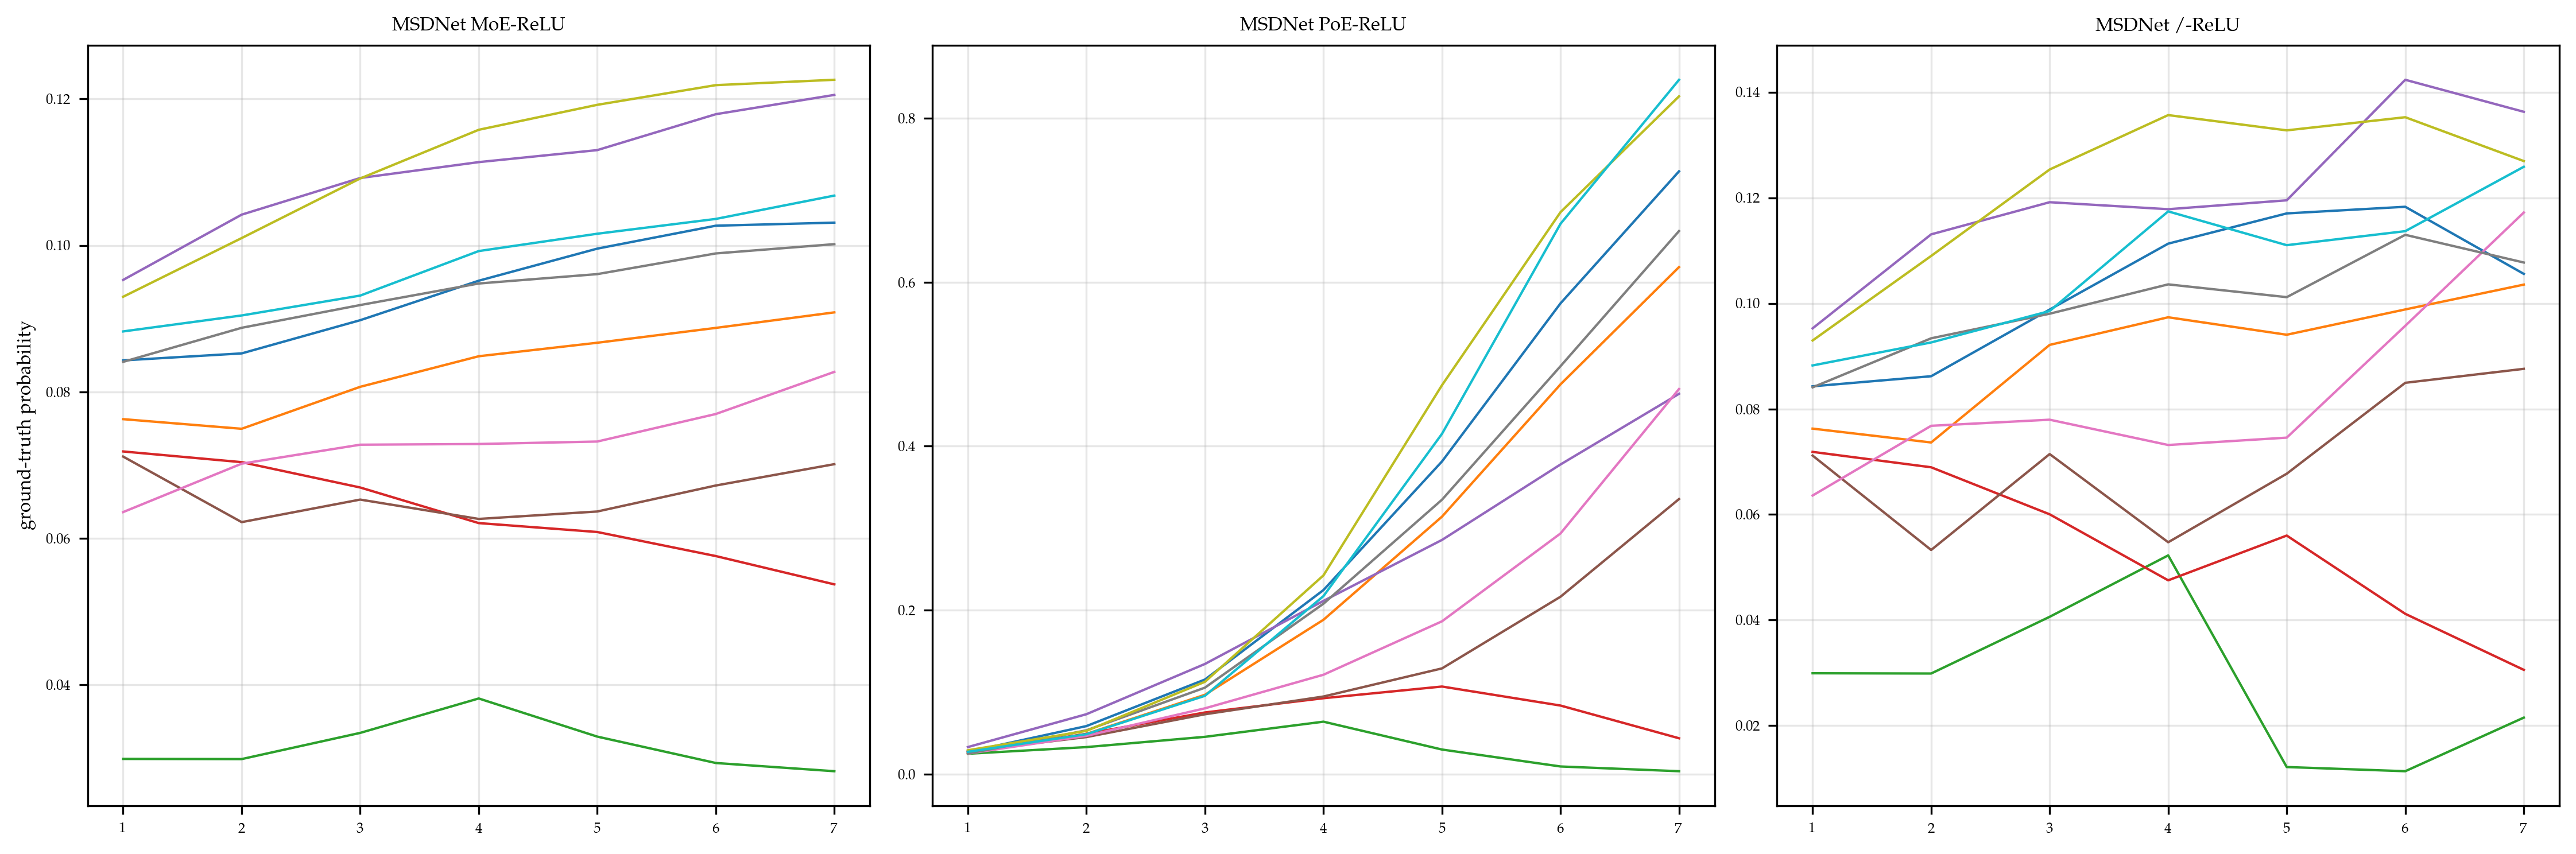

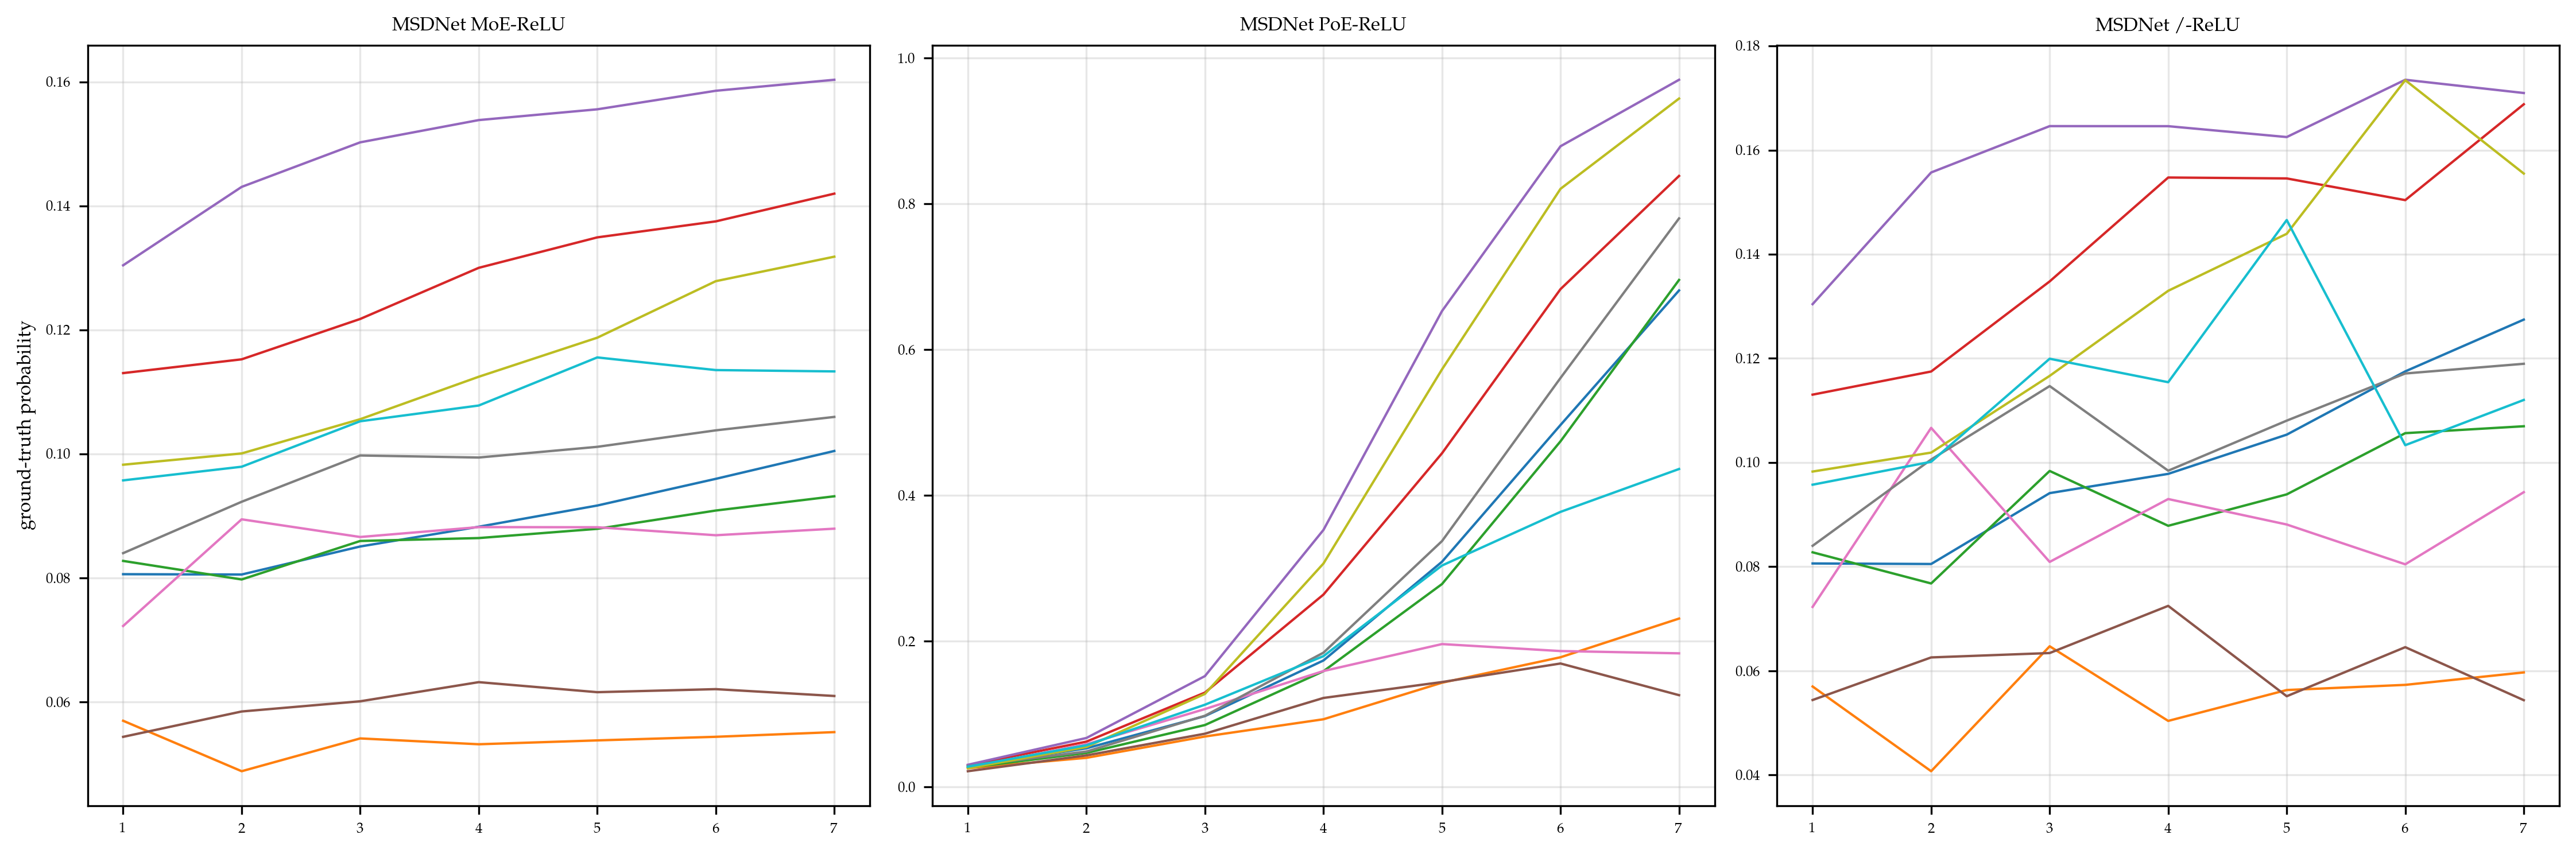

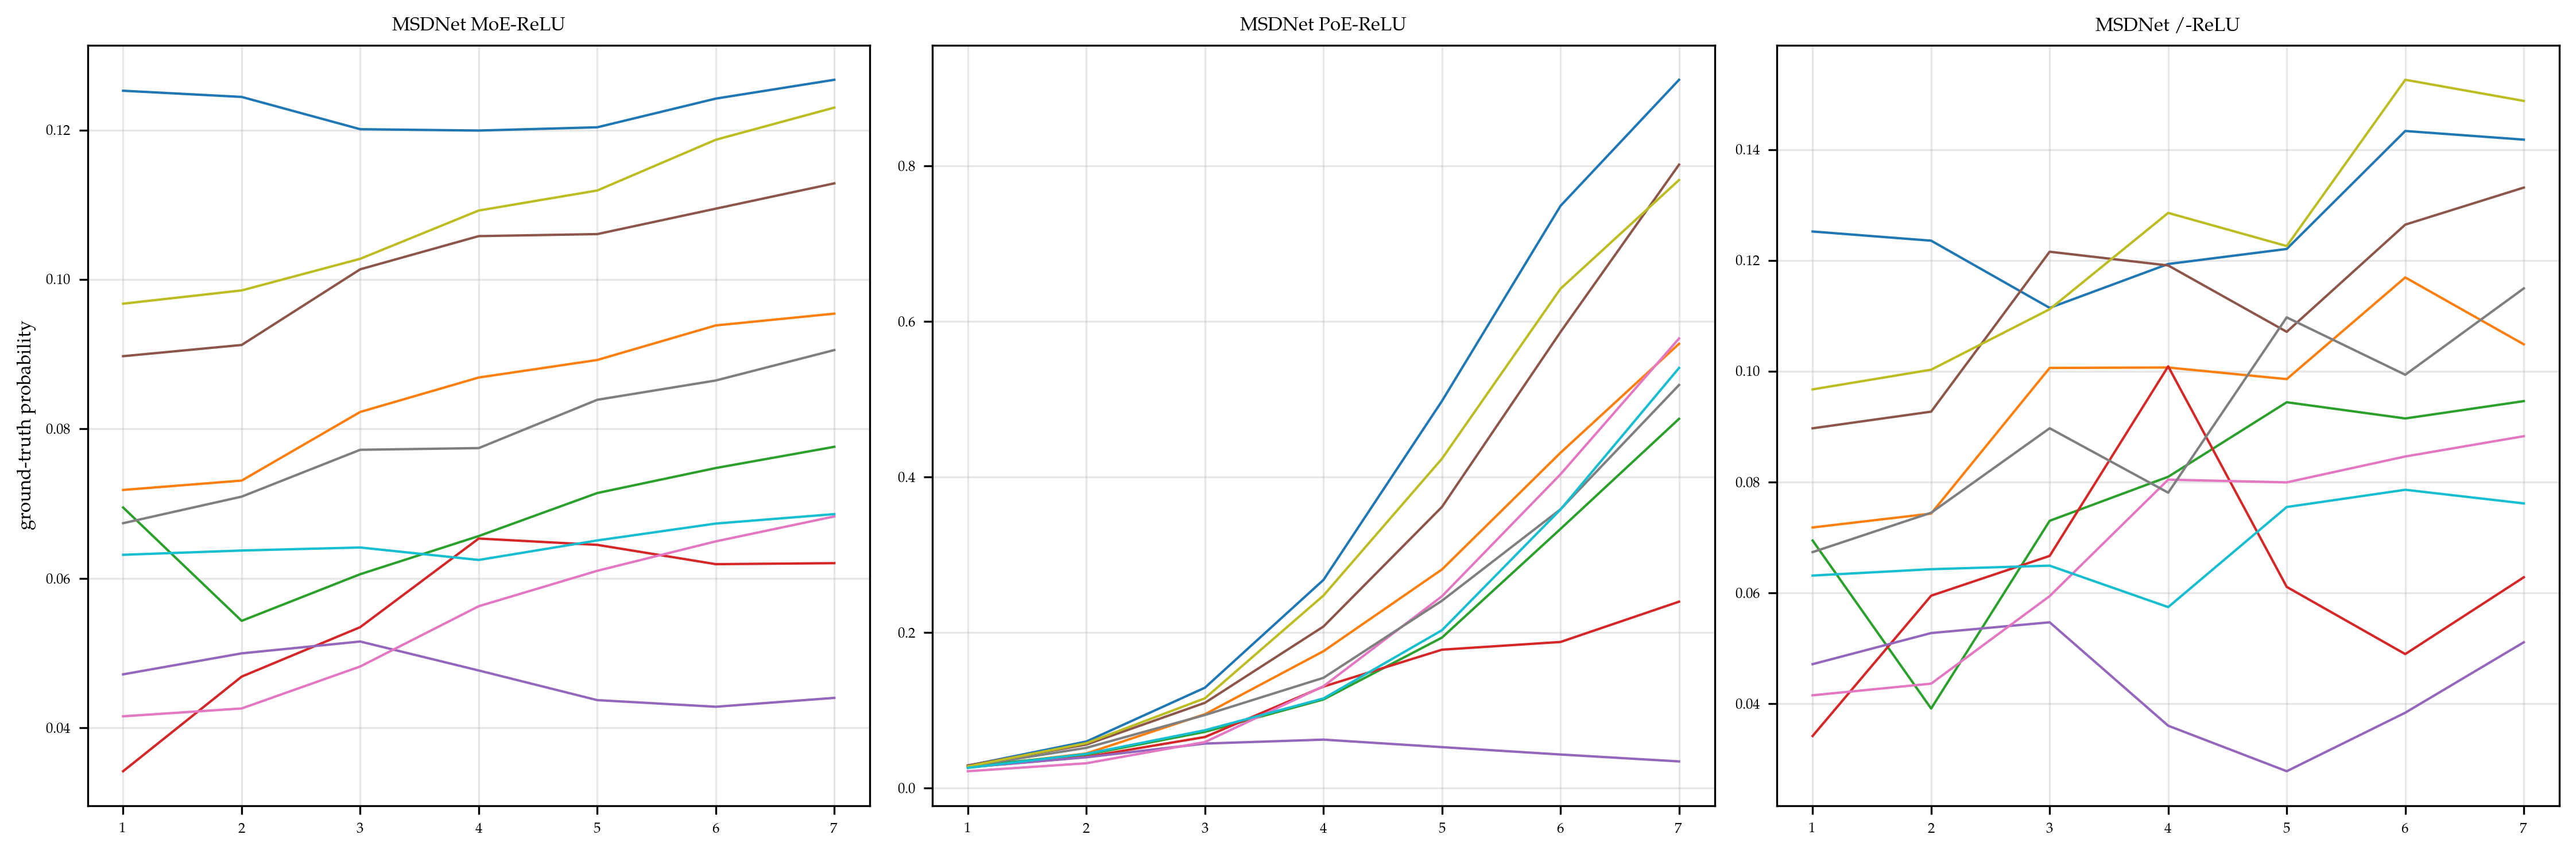

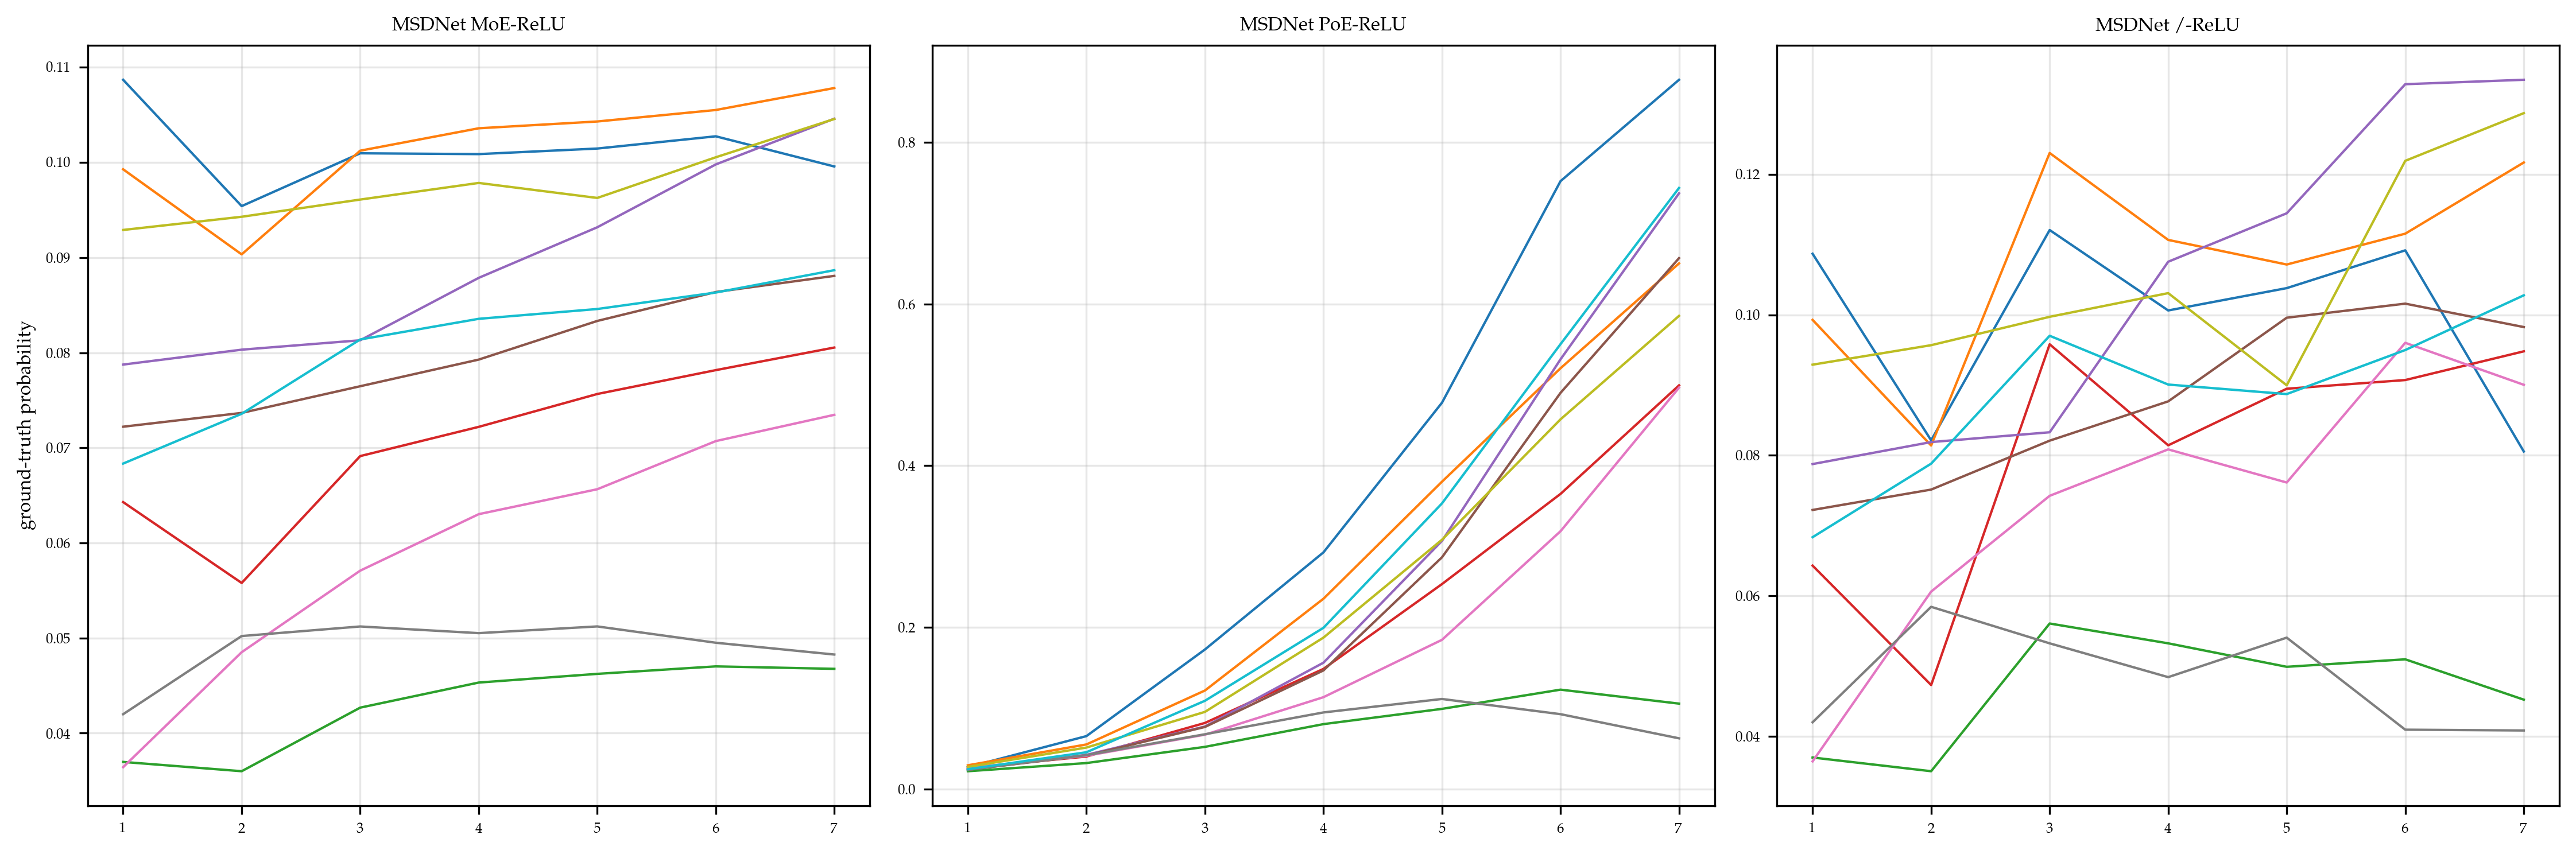

In [26]:
for _ in range(5):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    samples = random.sample(range(10000), 10)
    for i in samples:
        probs_i_no_ens = probs_ovr_break_ties[:, i, targets[i]].cpu()
        probs_i_moe = probs_moe_ovr_break_ties[:, i, targets[i]].cpu()
        probs_i_poe = probs_poe_ovr_break_ties[:, i, targets[i]].cpu()
        ax[0].plot(list(range(1, len(probs_i_moe) + 1)), probs_i_moe, label=f'{i}');
        ax[1].plot(list(range(1, len(probs_i_poe) + 1)), probs_i_poe, label=f'{i}');
        ax[2].plot(list(range(1, len(probs_i_no_ens) + 1)), probs_i_no_ens, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    # plt.legend()
    ax[0].set_title('MSDNet MoE-ReLU')
    ax[1].set_title('MSDNet PoE-ReLU')
    ax[2].set_title('MSDNet /-ReLU')
    ax[0].set_ylabel('ground-truth probability')
    plt.show()